## Notebook for training GPR on DC dataset and generating set of suggestions

**Created on 10th August, 2023; modified on 17th April, 2024**

**Dataset: label_ecfp_pca_add_feat_082423.csv**

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
## import train_test_split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, Matern, ConstantKernel, DotProduct, PairwiseKernel 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import SVG, display

import json
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, ColorBar, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, output_file, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256, d3
import pdb
output_notebook()

Loading BokehJS ...

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-6
total 2904
-rw-r--r--@ 1 riteshk  staff  1485993 Apr 17 14:10 sugg_gpr_bma_iter_6.ipynb


Finding smiles that have been labeled

In [3]:
df_unlabel = pd.read_csv('../campaign-5/unlabel_1mil_ecfp_pca_add_feat_iter_5.csv') ## unlabeled data created from iteration-5; initial unlabeled data (~1 mil)
df_unlabel.rename(columns={'Unnamed: 0':'index_3'}, inplace=True) ## change index accordingly, but original index is in index_0 column
df_unlabel

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,...,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2
1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,...,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2
2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,...,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2
3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,...,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2
4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,...,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,...,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,0.0,150,50,2
999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,...,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,0.0,150,50,2
999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,...,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,0.0,150,50,2
999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,...,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,0.0,150,50,2


In [4]:
def get_row(ind):
    sm = df_unlabel.loc[df_unlabel['index_0'] == ind]['solv_comb_sm']
    return df_unlabel.loc[df_unlabel['solv_comb_sm'] == sm.values[0]]

In [6]:
row_1 = get_row(324220)
row_1

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
324190,324195,324206,324220,CCCOP(=O)(F)OC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.006057,-1.338091,0.687763,0.419938,0.580514,...,0.258767,0.301779,-0.272648,260.0037,186.939685,1.0,0.0,150,50,2
630987,630998,631019,631045,CCCOP(=O)(F)OC(F)(F)C(F)(F)F,[Li+].F[P-](F)(F)(F)(F)F,-1.006057,-1.338091,0.687763,0.419938,0.580514,...,0.195230,0.319099,-0.209425,260.0037,151.980186,1.0,0.0,150,50,2


In [29]:
sm = Chem.MolFromSmiles('COCCOCC(OC)OC')
sm = Chem.MolFromSmiles('COCCCCCl')
sm = Chem.MolFromSmiles('COCC(C(F)(F)F)(F)F')
sm = Chem.MolFromSmiles('CCOCCOC')
sm = Chem.MolFromSmiles('COC1CCCCC1')
sm = Chem.MolFromSmiles('COCCCCCOC')
sm = Chem.MolFromSmiles('COCCCOC')
sm = Chem.MolFromSmiles('COCCCOCCCOC')
sm = Chem.MolFromSmiles('CS(=O)(=O)F')
sm = Chem.MolFromSmiles('COC(CCl)(CCl)OC')
sm = Chem.MolFromSmiles('COCCOCC(=O)OC')
df_unlabel.loc[df_unlabel['solv_comb_sm'] == Chem.MolToSmiles(sm)]

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
28840,28844,28845,28847,28850,COCCOCC(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.314981,0.184491,1.622378,-0.105444,...,0.258767,0.301779,-0.272648,148.073559,186.939685,1.0,0.0,150,50,2
379259,379273,379281,379296,379315,COCCOCC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,-1.314981,0.184491,1.622378,-0.105444,...,0.195230,0.319099,-0.209425,148.073559,151.980186,1.0,0.0,150,50,2
711634,711657,711669,711694,711725,COCCOCC(=O)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.314981,0.184491,1.622378,-0.105444,...,0.008496,0.161338,0.109063,148.073559,144.001775,1.0,0.0,150,50,2


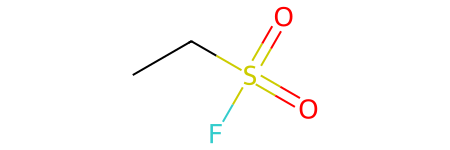

In [110]:
Chem.MolFromSmiles('COCCN(C)S(C)(=O)=O')
Chem.MolFromSmiles('CCS(=O)(=O)F')

In [33]:
## Finding labaled data from 3rd campaign
label_iter_6 = pd.DataFrame(columns=df_unlabel.columns)
## the code below will only extract one solvent entry; but we want all three solvent entries
row_1 = get_row(95164) ## CAS: 94158-44-8
row_2 = get_row(26842) ## CAS: 17913-18-7
row_3 = get_row(125071) ## CAS: 378-16-5
row_4 = get_row(3279) ## CAS: 5137-45-1
row_5 = get_row(231397) ## CAS: 931-56-6
row_6 = get_row(114563) ## CAS: 111-89-7
row_7 = get_row(31800) ## CAS: 17081-21-9
row_8 = get_row(134319) ## CAS: 66226-74-2
row_9 = get_row(22397) ## CAS: 558-25-8
row_10 = get_row(163051) ## CAS: 6626-57-9
row_11 = get_row(28850) ## CAS: 17640-28-7
label_iter_6 = pd.concat([label_iter_6, row_1, row_2, row_3, row_4, row_5, row_6, row_7, row_8, row_9, row_10, row_11], axis=0)
label_iter_6
# row_11

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
95144,95149,95152,95158,95164,COCCOCC(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.171924,-1.054353,0.913877,-0.509980,...,0.258767,0.301779,-0.272648,164.104859,186.939685,1.0,0.0,150,50,2
424092,424107,424116,424134,424155,COCCOCC(OC)OC,[Li+].F[P-](F)(F)(F)(F)F,-1.171924,-1.054353,0.913877,-0.509980,...,0.195230,0.319099,-0.209425,164.104859,151.980186,1.0,0.0,150,50,2
753070,753093,753106,753133,753166,COCCOCC(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.171924,-1.054353,0.913877,-0.509980,...,0.008496,0.161338,0.109063,164.104859,144.001775,1.0,0.0,150,50,2
26834,26837,26838,26839,26842,COCCCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.895787,-1.564556,0.936152,-0.167522,...,0.258767,0.301779,-0.272648,122.049843,186.939685,1.0,0.0,150,50,2
373001,373015,373023,373037,373055,COCCCCCl,[Li+].F[P-](F)(F)(F)(F)F,-0.895787,-1.564556,0.936152,-0.167522,...,0.195230,0.319099,-0.209425,122.049843,151.980186,1.0,0.0,150,50,2
699435,699458,699470,699493,699523,COCCCCCl,[Li+].O=C1O[B-](F)(F)OC1=O,-0.895787,-1.564556,0.936152,-0.167522,...,0.008496,0.161338,0.109063,122.049843,144.001775,1.0,0.0,150,50,2
125047,125053,125056,125062,125071,COCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.682909,-1.492217,1.039659,-0.738617,...,0.258767,0.301779,-0.272648,164.026056,186.939685,1.0,0.0,150,50,2
389867,389881,389890,389906,389926,COCC(F)(F)C(F)(F)F,[Li+].F[P-](F)(F)(F)(F)F,-0.682909,-1.492217,1.039659,-0.738617,...,0.195230,0.319099,-0.209425,164.026056,151.980186,1.0,0.0,150,50,2
754593,754617,754630,754657,754690,COCC(F)(F)C(F)(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,-0.682909,-1.492217,1.039659,-0.738617,...,0.008496,0.161338,0.109063,164.026056,144.001775,1.0,0.0,150,50,2
3277,3278,3278,3278,3279,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,...,0.258767,0.301779,-0.272648,104.083730,186.939685,1.0,0.0,150,50,2


In [34]:
label_iter_6['solv_comb_sm'].unique()

array(['COCCOCC(OC)OC', 'COCCCCCl', 'COCC(F)(F)C(F)(F)F', 'CCOCCOC',
       'COC1CCCCC1', 'COCCCCCOC', 'COCCCOC', 'COCCCOCCCOC', 'CS(=O)(=O)F',
       'COC(CCl)(CCl)OC', 'COCCOCC(=O)OC'], dtype=object)

In [35]:
df_unlabel_ = df_unlabel.drop(label_iter_6.index) ## drop the labeled molecules from the unlabeled data
df_unlabel_

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,...,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2
1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,...,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2
2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,...,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2
3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,...,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2
4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,...,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,...,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,0.0,150,50,2
999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,...,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,0.0,150,50,2
999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,...,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,0.0,150,50,2
999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,...,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,0.0,150,50,2


In [36]:
df_unlabel_.to_csv('unlabel_1mil_ecfp_pca_add_feat_iter_6.csv') ## save the unlabeled data for the next iteration
# df_unlabel_ = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat_iter_6.csv') ## read the unlabeled data for the next iteration
# df_unlabel_

In [37]:
label_iter_6.to_csv('just_label_iter_6.csv', index=False) ## also save the labeled data from the 6th iteration of suggestions
# label_iter_5 = pd.read_csv('just_label_iter_5.csv') ## read the labeled data labeled data from the 6th iteration of suggestions
# label_iter_5

In [38]:
df = pd.read_csv('label_ecfp_pca_add_feat_iter_6_041724.csv') ## added the labeled data from the 5th iteration of suggestions to the labeled data from 4th iteration manually
df

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,CS(=O)(=O)F,[Li+].O=C1O[B-](F)(F)OC1=O,-0.343456,-1.452368,0.339526,0.176204,0.897094,-0.507669,-0.378477,-0.085316,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
179,COC(CCl)(CCl)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.715544,-1.384987,0.702147,-0.545643,0.424318,0.071399,0.660587,0.237141,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
180,COCCOCC(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.314981,0.184491,1.622378,-0.105444,-0.221744,0.414074,0.458720,0.608244,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
181,COCCOCC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,-1.314981,0.184491,1.622378,-0.105444,-0.221744,0.414074,0.458720,0.608244,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [39]:
df['theor_capacity'].unique()

array([150, 203, 161])

In [40]:
## Important change: on 24th August, 2023
df_ = df.copy()
df_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,CS(=O)(=O)F,[Li+].O=C1O[B-](F)(F)OC1=O,-0.343456,-1.452368,0.339526,0.176204,0.897094,-0.507669,-0.378477,-0.085316,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
179,COC(CCl)(CCl)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.715544,-1.384987,0.702147,-0.545643,0.424318,0.071399,0.660587,0.237141,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
180,COCCOCC(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.314981,0.184491,1.622378,-0.105444,-0.221744,0.414074,0.458720,0.608244,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
181,COCCOCC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,-1.314981,0.184491,1.622378,-0.105444,-0.221744,0.414074,0.458720,0.608244,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [41]:
X = df_.iloc[:,2:27]
y = df_['norm_capacity_3']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## will be using complete dataset for training
# X_test
X

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,-0.780469,-0.407588,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,90.068080,186.939685,1.0,150,50
1,-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,-0.507040,-0.352331,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,118.099380,186.939685,1.0,150,50
2,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,132.115030,186.939685,1.0,150,50
3,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,132.115030,186.939685,1.0,150,50
4,-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,0.099267,-0.130341,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,146.130680,186.939685,2.2,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,-0.343456,-1.452368,0.339526,0.176204,0.897094,-0.507669,-0.378477,-0.085316,-0.729511,-0.612523,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,97.983779,144.001775,1.0,150,50
179,-0.715544,-1.384987,0.702147,-0.545643,0.424318,0.071399,0.660587,0.237141,-0.253941,-0.292156,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,172.005785,186.939685,1.0,150,50
180,-1.314981,0.184491,1.622378,-0.105444,-0.221744,0.414074,0.458720,0.608244,-0.832032,-0.491760,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,148.073559,186.939685,1.0,150,50
181,-1.314981,0.184491,1.622378,-0.105444,-0.221744,0.414074,0.458720,0.608244,-0.832032,-0.491760,...,0.203690,-0.160053,0.195230,0.319099,-0.209425,148.073559,151.980186,1.0,150,50


In [42]:
std_scale_ = StandardScaler().fit(X)
X_std = std_scale_.transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [43]:
kernel_1 = PairwiseKernel(metric='polynomial') + WhiteKernel(noise_level=0.1)
kernel_3 = RBF(length_scale=0.01) + WhiteKernel(noise_level=0.1)
kernel_2 = Matern(length_scale=0.01, nu=2.5) + WhiteKernel(noise_level=0.1)
kernel_4 = Matern(length_scale=0.01, nu=1.5) + WhiteKernel(noise_level=0.1)
kernel_5 = ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.1)
kernel_6 = RationalQuadratic(length_scale=0.01, alpha=1.0) + WhiteKernel(noise_level=0.1)
kernel_7 = DotProduct(sigma_0=0.1) + WhiteKernel(noise_level=0.1)
kernel_8 = RBF(length_scale=0.01) + ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.1)
kernels = [kernel_1, kernel_2, kernel_3, kernel_4, kernel_5, kernel_6, kernel_7, kernel_8]
kernel_name = ['PairwiseKernel', 'Matern 5/2', 'RBF', 'Matern 3/2', 'ExpSineSquared', 'RationalQuadratic', 'DotProduct', 'RBF+ExpSineSquared']
cv_dict = {'kernel': list(), 'score': list()}

In [44]:
# def negative_log_likelihood(noise_level, length_scale, alpha, kernel_name):
# def negative_log_likelihood(params, kernel_name):
def negative_log_likelihood_rbf(params):
    noise_level, length_scale, alpha = params ## for adding regularization parameter
    # noise_level, length_scale = params ## in case of not adding regularization parameter
    # if kernel_name == 'RBF':
    kernel = RBF(length_scale=length_scale)
    # elif kernel_name == 'Matern-5/2':
        # kernel = Matern(length_scale=length_scale, nu=2.5)
    # elif kernel_name == 'Pairwise':
        # kernel = PairwiseKernel(metric='polynomial')
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    # gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=0.0, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=0) ## in case of not adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_rq(params):
    noise_level, length_scale, alpha_k, alpha = params ## for adding regularization parameter
    kernel = RationalQuadratic(length_scale=length_scale, alpha=alpha_k)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_rbf_expsin(params):
    noise_level, length_scale, periodicity, alpha = params ## for adding regularization parameter
    kernel = RBF(length_scale=length_scale) + ExpSineSquared(length_scale=length_scale, periodicity=periodicity)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_matern(params):
    noise_level, length_scale, alpha = params
    kernel = Matern(length_scale=length_scale, nu=1.5)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_pairwise(params):
    noise_level, length_scale, alpha = params
    kernel = PairwiseKernel(metric="polynomial")
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

**Optimize Pairwise kernel**

In [45]:
initial_guess = [0.15, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha
result = minimize(negative_log_likelihood_pairwise, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of i

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha: 0.0001


In [46]:
optimized_kernel = PairwiseKernel(metric="polynomial") + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.4965789680715398
MAE: 0.16380945378156034
RMSE: 0.20747889609714262


In [47]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

PairwiseKernel(gamma=0.000742717092667539, metric=polynomial) + WhiteKernel(noise_level=0.0474)

In [48]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.367381,0.221078
1,0.661460,0.273415,0.223440
2,0.178387,0.315116,0.223876
3,0.216953,0.315116,0.223876
4,0.026187,0.439080,0.230357
...,...,...,...
178,0.000000,-0.025488,0.229598
179,0.000000,0.217803,0.220461
180,0.000067,0.318080,0.228150
181,0.000067,0.210453,0.231685


**Optimize RationalQuadratic kernel**

In [49]:
initial_guess = [0.15, 0.01, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha_k, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha_k, alpha
result = minimize(negative_log_likelihood_rq, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha_k, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha_k:", optimized_alpha_k)
print("Optimized alpha:", optimized_alpha)

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha_k: 0.01
Optimized alpha: 0.010101643025496956


In [50]:
optimized_kernel = RationalQuadratic(length_scale=optimized_length_scale, alpha=optimized_alpha_k) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.5815868847417373
MAE: 0.14109213630104256
RMSE: 0.1891519816046777


In [51]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

RationalQuadratic(alpha=0.0756, length_scale=19) + WhiteKernel(noise_level=0.0328)

In [52]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.364685,0.188686
1,0.661460,0.271233,0.191659
2,0.178387,0.296832,0.192401
3,0.216953,0.296832,0.192401
4,0.026187,0.403875,0.206463
...,...,...,...
178,0.000000,-0.013016,0.208094
179,0.000000,0.254169,0.187134
180,0.000067,0.222700,0.205184
181,0.000067,0.156062,0.214119


**Optimize Matern-3/2 kernel**

In [53]:
initial_guess = [0.15, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha
result = minimize(negative_log_likelihood_matern, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha:", optimized_alpha)

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha: 0.00995900793346562


In [54]:
optimized_kernel = Matern(length_scale=optimized_length_scale, nu=1.5) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.5603739057616677
MAE: 0.14768301119383448
RMSE: 0.1938875764128036


In [55]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

Matern(length_scale=31.3, nu=1.5) + WhiteKernel(noise_level=0.0339)

In [56]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.365413,0.190638
1,0.661460,0.271972,0.193438
2,0.178387,0.304373,0.194082
3,0.216953,0.304373,0.194082
4,0.026187,0.429018,0.205556
...,...,...,...
178,0.000000,-0.022647,0.206318
179,0.000000,0.241026,0.189461
180,0.000067,0.258002,0.203662
181,0.000067,0.175865,0.210773


**Optimize RBF-ExpineSquared kernel**

In [57]:
initial_guess = [0.15, 0.01, 1.0, 0.02] # initial guess for noise_level, length_scale, periodicity, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-2, 10.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, periodicity, alpha
result = minimize(negative_log_likelihood_rbf_expsin, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_periodicity, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized periodicity:", optimized_periodicity)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as show

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized periodicity: 1.0
Optimized alpha: 0.0199927602324515


In [58]:
optimized_kernel = RBF(length_scale=optimized_length_scale) + ExpSineSquared(length_scale=optimized_length_scale, periodicity=optimized_periodicity) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.518566454534334
MAE: 0.15808771205472033
RMSE: 0.20289737334500513


In [59]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

RBF(length_scale=19.2) + ExpSineSquared(length_scale=83.7, periodicity=0.0022) + WhiteKernel(noise_level=0.0281)

In [60]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.368076,0.173022
1,0.661460,0.280577,0.176026
2,0.178387,0.309081,0.176937
3,0.216953,0.309081,0.176937
4,0.026187,0.457100,0.186077
...,...,...,...
178,0.000000,-0.031086,0.185431
179,0.000000,0.221014,0.172241
180,0.000067,0.306477,0.183537
181,0.000067,0.190184,0.189040


**Production runs**

In [61]:
# df_unlabel = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat.csv')
# df_unlabel_ = df_unlabel.copy()
df_unlabel_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_unlabel_

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,150,50
1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,150,50
2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,150,50
3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,150,50
4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,150,50
999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,150,50
999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,150,50
999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,150,50


In [62]:
# uniq_smiles = df_unlabel_['smiles'].unique()
df_unlabel_uniq = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
df_unlabel_uniq

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,150,50
1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,150,50
2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,150,50
3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,150,50
4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999872,999899,999915,999946,999984,CCCCN1C(=O)OCC1[SiH](C)C,[Li+].O=C1O[B-](F)(F)OC1=O,0.627609,-0.998588,-0.085111,1.419019,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,201.118505,144.001775,1.0,150,50
999874,999901,999917,999948,999986,CC(C)(C)C(=O)N1C2CCC1COC2,[Li+].O=C1O[B-](F)(F)OC1=O,0.902927,0.033572,0.856049,-0.034590,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,197.141579,144.001775,1.0,150,50
999875,999902,999918,999949,999987,CC(C)(C)C(=O)CS(=O)(=O)CC(=O)N1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.621175,0.407378,0.570353,0.639576,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,275.119129,144.001775,1.0,150,50
999876,999903,999919,999950,999988,CCO[Si](CCC(C)SC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.112749,-1.140740,0.140488,-0.169667,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,238.105892,144.001775,1.0,150,50


In [64]:
# df_unlabel_.drop(columns=['Unnamed: 0'], inplace=True)
X_un = df_unlabel_.iloc[:,6:] ## change it for every new iteration
X_un_std = std_scale_.transform(X_un)
X_un_std = pd.DataFrame(X_un_std, columns=X_un.columns)
# X_std = std_scale_.transform(X)
# X_std = pd.DataFrame(X_std, columns=X.columns)
X_un_std

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0.231407,0.661083,-2.328548,-0.251237,1.831727,-0.522719,-0.863445,-0.007918,-1.241108,0.287985,...,0.415906,-0.770321,0.644659,0.436110,-0.593516,-1.401363,0.58105,-0.271674,-0.278089,0.206336
1,1.960414,0.771636,-0.025616,1.580341,1.329905,-2.503121,-0.345233,1.392948,-1.270244,0.239013,...,0.415906,-0.770321,0.644659,0.436110,-0.593516,-0.678364,0.58105,-0.271674,-0.278089,0.206336
2,-0.086253,2.865488,-1.948909,-0.199787,2.547107,-0.722556,-1.045906,-0.117993,-1.218208,0.337113,...,0.415906,-0.770321,0.644659,0.436110,-0.593516,-0.642843,0.58105,-0.271674,-0.278089,0.206336
3,0.453971,-0.227156,-0.187581,0.180556,1.423269,-1.153481,-0.777672,-0.290892,-1.798888,0.316546,...,0.415906,-0.770321,0.644659,0.436110,-0.593516,-1.454121,0.58105,-0.271674,-0.278089,0.206336
4,0.285734,0.755979,-2.420014,-0.540687,1.867995,-0.817228,-0.836914,0.095905,-1.321178,0.282059,...,0.415906,-0.770321,0.644659,0.436110,-0.593516,-1.419123,0.58105,-0.271674,-0.278089,0.206336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999851,1.646785,0.309018,-0.343822,0.729714,1.197449,-1.649987,-0.707124,-0.048508,-2.240004,2.006203,...,-1.953078,1.601036,-1.950488,-1.966747,1.977833,0.713794,-1.22262,-0.271674,-0.278089,0.206336
999852,1.789737,4.070359,2.579745,0.879276,0.235748,-1.120857,-0.960833,2.818964,2.017014,-1.196650,...,-1.953078,1.601036,-1.950488,-1.966747,1.977833,1.543298,-1.22262,-0.271674,-0.278089,0.206336
999853,1.556357,3.989282,1.759024,1.710191,-0.091193,-0.366286,-0.112168,-1.201103,-0.435065,1.447036,...,-1.953078,1.601036,-1.950488,-1.966747,1.977833,1.735367,-1.22262,-0.271674,-0.278089,0.206336
999854,1.372102,4.653468,-2.236041,-0.851140,1.463831,1.345207,-1.491146,-0.125356,0.553779,-0.565803,...,-1.953078,1.601036,-1.950488,-1.966747,1.977833,1.684037,-1.22262,-0.271674,-0.278089,0.206336


In [65]:
## final corrected & verified one to be used
def EI_(y_pred, y_pred_un, y_pred_un_uncer, epsilon=0.01):
    y_best = np.max(y_pred)
    EI = []

    for i in range(len(y_pred_un)):
        if y_pred_un_uncer[i] != 0:
            # Calculate the cumulative distribution function (CDF) for the Gaussian distribution
            z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            # z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            cdf_z = 0.5 * (1 + erf(z / np.sqrt(2)))
            pdf_z = np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)

            # Calculate the probability of improvement
            # probability_improvement = y_pred_un_uncer[i] * (z * cdf_z + np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi))

            # Calculate Expected Improvement
            expected_improvement = y_pred_un_uncer[i] * (z * cdf_z) + y_pred_un_uncer[i] * pdf_z
            EI.append(expected_improvement)
        else:
            EI.append(0.0)
    return EI

**Bayesian model averaging (BMA)**

In [66]:
## change all hyperparameters accordingly
optimized_pairwise_kernel = PairwiseKernel(metric="polynomial") + WhiteKernel(noise_level=0.15)
optimized_matern_kernel = Matern(length_scale=0.01, nu=1.5) + WhiteKernel(noise_level=0.15)
optimized_rbfexpsin_kernel = RBF(length_scale=0.01) + ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.15)
optimized_rq_kernel = RationalQuadratic(length_scale=0.01, alpha=0.01) + WhiteKernel(noise_level=0.15)
# kernels = [RBF(length_scale=1.0), Matern(length_scale=1.0, nu=1.5)]
gpr_models = [GaussianProcessRegressor(kernel=optimized_pairwise_kernel, alpha=0.0001, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_matern_kernel, alpha=0.00995900793346562, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_rq_kernel, alpha=0.010101643025496956, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_rbfexpsin_kernel, alpha=0.0199927602324515, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)]

k = 0
for model in gpr_models:
    print("fitting model: ", k)
    model.fit(X_std, y)
    k += 1

fitting model:  0
fitting model:  1
fitting model:  2
fitting model:  3


In [67]:
# Calculate Model Weights using BMA (first order)
model_names = ['pairwise_iter6_041724.pkl', 'matern_iter6_041724.pkl', 'rq_iter5_041724.pkl', 'rbfexpsin_iter5_041724.pkl']
model_weights = []
uncertainties = []
predictions = []
y_label_preds = []
for model in gpr_models:
    y_un = model.predict(X_un_std)
    predictions.append(y_un)
    individual_uncertainties = model.predict(X_un_std, return_std=True)[1]
    uncertainties.append(individual_uncertainties)
    likelihoods = norm.pdf(y_un, loc=model.predict(X_un_std), scale=individual_uncertainties)
    prior_beliefs = 1.0  # Non-informative prior
    posterior = likelihoods * prior_beliefs
    model_weights.append(posterior / np.sum(posterior))
    y_ = model.predict(X_std)
    y_label_preds.append(y_)

# Step 4: Calculate Combined Predictions using Model Weights
combined_predictions = np.zeros_like(y_un)
for i, model in enumerate(gpr_models):
    combined_predictions += model.predict(X_un_std) * model_weights[i]
    pickle.dump(model, open(model_names[i], 'wb'))

# Step 5: Select Most Informative Data Points
# informative_indices = np.argsort(combined_predictions)[-num_samples_to_label:]

# Label the selected data points and add them to the labeled set
# labeled_X = X_un_std[informative_indices]
# labeled_y = y_un[informative_indices]
# X_labeled = np.vstack((X_std, labeled_X))
# y_labeled = np.hstack((y, labeled_y))

# # Remove the labeled data points from the unlabeled pool
# # X_unlabeled = np.delete(X_un_std, informative_indices, axis=0)
# # y_unlabeled = np.delete(y_un, informative_indices, axis=0)

# # Retrain GPR models using updated labeled set
# for model in gpr_models:
#     model.fit(X_labeled, y_labeled)

In [68]:
combined_uncertainties = np.sqrt(np.sum((np.array(uncertainties) * np.array(model_weights)) ** 2, axis=0))
combined_uncertainties

array([4.71320828e-07, 4.71320828e-07, 4.71320828e-07, ...,
       4.71320828e-07, 4.71320828e-07, 4.71320828e-07])

In [69]:
# model_weights
combined_predictions
min(individual_uncertainties)
# individual_uncertainties
uncertainties
max(uncertainties[3])
# min(uncertainties[2])

0.4024776783561113

In [70]:
df_unlabel_['norm_capacity_3_pred'] = combined_predictions
df_unlabel_['norm_capacity_3_uncer'] = combined_uncertainties
df_unlabel_['norm_capacity_3_pair'] = predictions[0]
df_unlabel_['norm_capacity_3_un_pair'] = uncertainties[0]
df_unlabel_['norm_capacity_3_matern'] = predictions[1]
df_unlabel_['norm_capacity_3_un_matern'] = uncertainties[1]
df_unlabel_['norm_capacity_3_rq'] = predictions[2]
df_unlabel_['norm_capacity_3_un_rq'] = uncertainties[2]
df_unlabel_['norm_capacity_3_rbfexpsin'] = predictions[3]
df_unlabel_['norm_capacity_3_un_rbfexpsin'] = uncertainties[3]
df_unlabel_['EI_pair'] = EI_(y_label_preds[0], predictions[0], uncertainties[0])
df_unlabel_['EI_matern'] = EI_(y_label_preds[1], predictions[1], uncertainties[1])
df_unlabel_['EI_rq'] = EI_(y_label_preds[2], predictions[2], uncertainties[2])
df_unlabel_['EI_rbfexpsin'] = EI_(y_label_preds[3], predictions[3], uncertainties[3])
df_unlabel_['EI_aggr'] = df_unlabel_['EI_pair']*model_weights[0] + df_unlabel_['EI_matern']*model_weights[1] + df_unlabel_['EI_rq']*model_weights[2] + df_unlabel_['EI_rbfexpsin']*model_weights[3]
df_unlabel_

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,...,0.210652,0.036388,0.213131,-0.028833,0.190237,4.352759e-07,9.271914e-07,0.000017,4.484913e-09,2.056377e-11
1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,...,0.220329,0.020779,0.223812,0.000191,0.199810,1.777955e-06,2.647597e-06,0.000025,3.790661e-08,3.210314e-11
2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,...,0.224994,-0.048656,0.230271,-0.124979,0.203155,1.163366e-07,3.916610e-07,0.000012,2.125906e-09,1.264102e-11
3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,...,0.202038,0.136671,0.202137,0.127638,0.183898,4.991655e-06,6.659768e-06,0.000051,1.425624e-07,7.471900e-11
4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,...,0.213684,0.025879,0.216916,-0.030867,0.192918,3.926163e-07,9.149222e-07,0.000018,6.352898e-09,2.134848e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,...,0.237545,-0.069872,0.243804,-0.166776,0.213277,1.192621e-07,7.913179e-07,0.000019,3.046115e-09,1.959003e-11
999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,...,0.253165,-0.070840,0.260922,-0.109416,0.226576,5.935917e-07,4.345367e-06,0.000047,6.411212e-08,4.814291e-11
999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,...,0.254593,0.017982,0.263059,-0.023406,0.228187,3.023526e-06,2.070834e-05,0.000172,4.757334e-07,1.809392e-10
999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,...,0.265095,-0.085858,0.273279,-0.237278,0.236896,6.853827e-08,2.912628e-06,0.000068,1.161471e-08,6.318782e-11


In [71]:
max(model_weights[0])
# min(combined_uncertainties)
# max(combined_uncertainties)
# min(df_unlabel_['EI_aggr'])

1.1411939103881352e-06

In [72]:
df_unlabel_.to_csv('preds_uncer_ei_unlabel_1mil_iter6_041724.csv', index=False) ## saving predictions for the unlabeled data (for 4th set of suggestions)
# df_unlabel_ = pd.read_csv('preds_uncer_ei_unlabel_1mil_iter5_031424.csv') ## reading predictions for the unlabeled data (for 4th set of suggestions)
# df_unlabel_

In [73]:
df_new = df_unlabel_.copy()
df_new.sort_values(by=['EI_aggr'], ascending=False, inplace=True) ## sorting in descending order of EI_aggr => df_new is the dataframe that is sorted according to the EI_aggr
df_new_ = df_new.iloc[:100,:]
df_new_

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,-0.295080,...,0.196289,0.524380,0.196219,0.533146,0.177322,0.001487,0.003511,0.010296,0.000549,1.922895e-08
163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,-0.453350,...,0.194989,0.524388,0.194395,0.530847,0.176377,0.001314,0.003253,0.009959,0.000506,1.840467e-08
86859,86864,86867,86873,86879,COCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.733879,-1.391349,0.795406,-0.490061,...,0.194749,0.524147,0.193976,0.523709,0.176226,0.001284,0.003195,0.009857,0.000445,1.813241e-08
170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,-0.411474,...,0.194047,0.523170,0.193056,0.512665,0.175746,0.001152,0.003006,0.009587,0.000359,1.738860e-08
297404,297413,297418,297428,297442,COCCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.776737,-1.511074,0.882413,-0.374763,...,0.194727,0.521344,0.194054,0.511455,0.176446,0.001187,0.003040,0.009577,0.000363,1.738485e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199755,199762,199765,199774,199786,COCCCC(C)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.000838,-1.570611,1.045125,-0.429592,...,0.193956,0.461308,0.192169,0.424221,0.176931,0.000397,0.001103,0.004610,0.000073,7.672464e-09
869623,869649,869664,869693,869730,COCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.394637,-0.462672,0.854416,-0.416162,...,0.219502,0.405314,0.223832,0.386440,0.196957,0.000409,0.001501,0.005053,0.000120,7.631813e-09
113006,113012,113015,113021,113030,COCCCOCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.817849,-1.279554,0.435669,-0.652919,...,0.198330,0.447241,0.198288,0.445430,0.179472,0.000495,0.001193,0.004516,0.000129,7.627615e-09
199574,199581,199584,199593,199605,COCCCOCOOOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.669923,-1.401988,0.768304,-0.236070,...,0.193027,0.451102,0.191738,0.477855,0.174979,0.000670,0.001240,0.004020,0.000183,7.561366e-09


In [127]:
# df_new_.to_csv('top100_sugg_ei_test2.csv', index=False)

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_76694/3389624811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_['pred_comb'] = df_new_.apply(lambda x: str(format(x['norm_capacity_3_pred'],".1e")) + ', ' + str(format(x['norm_capacity_3_uncer'],".1e")) + ', ' + str(format(x['EI_aggr'],".1e")), axis=1)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].m

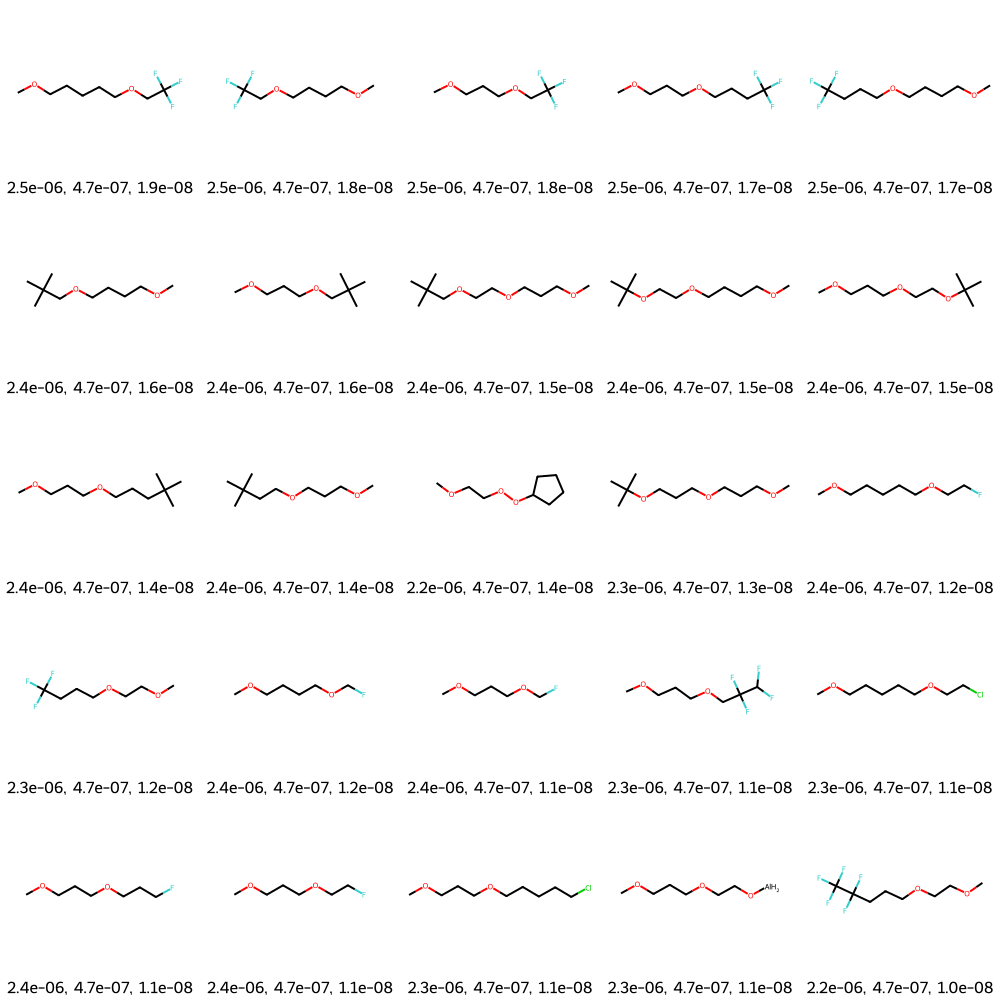

In [74]:
# df_new_['pred_uncertainty'] = df_new_.apply(lambda x: str(round(x['norm_capacity_3_pred'],3)) + ', ' + str(round(x['norm_capacity_3_uncer'],3)) + ', ' + str(round(x['EI_weight_av'],3)), axis=1)
df_new_['pred_comb'] = df_new_.apply(lambda x: str(format(x['norm_capacity_3_pred'],".1e")) + ', ' + str(format(x['norm_capacity_3_uncer'],".1e")) + ', ' + str(format(x['EI_aggr'],".1e")), axis=1)
PandasTools.AddMoleculeColumnToFrame(df_new_, smilesCol='solv_comb_sm')
# PandasTools.FrameToGridImage(df_, legendsCol="norm_capacity_3_pred", molsPerRow=6)
PandasTools.FrameToGridImage(df_new_.iloc[:25], legendsCol="pred_comb", molsPerRow=5)

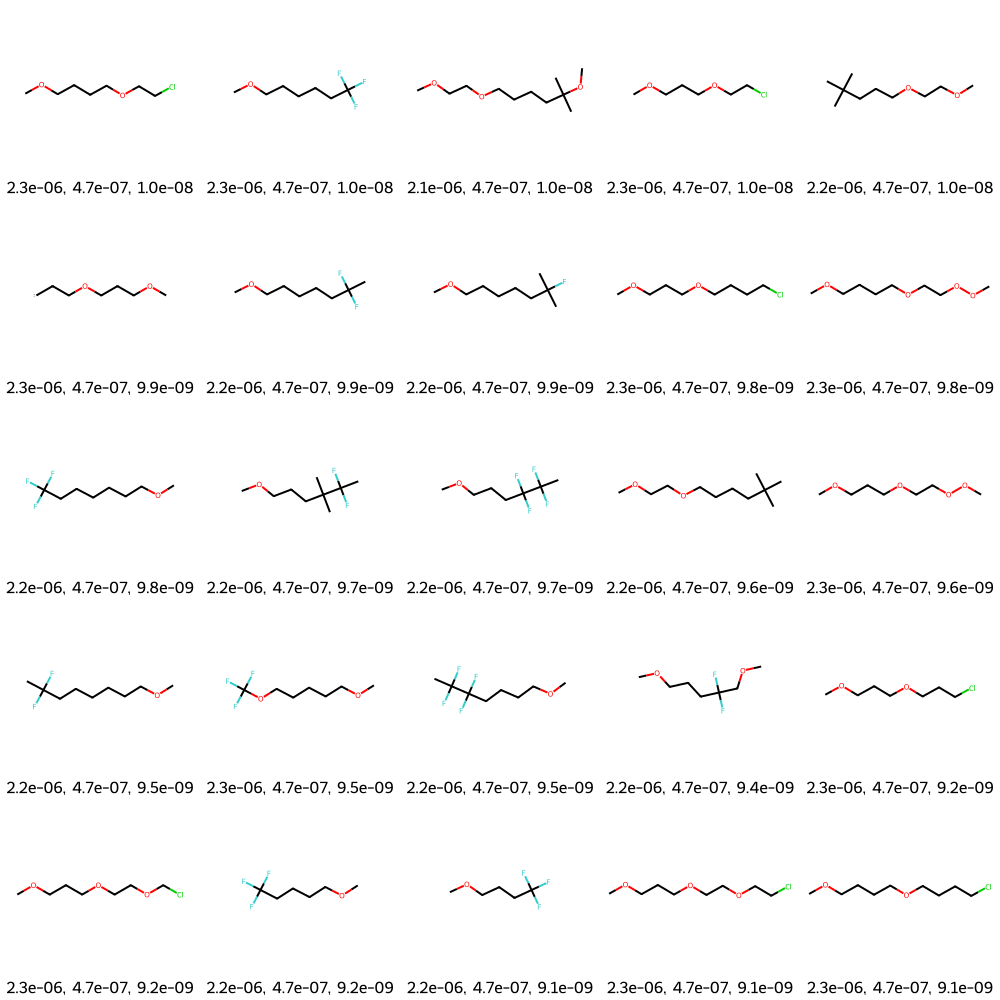

In [75]:
PandasTools.FrameToGridImage(df_new_.iloc[25:50], legendsCol="pred_comb", molsPerRow=5)

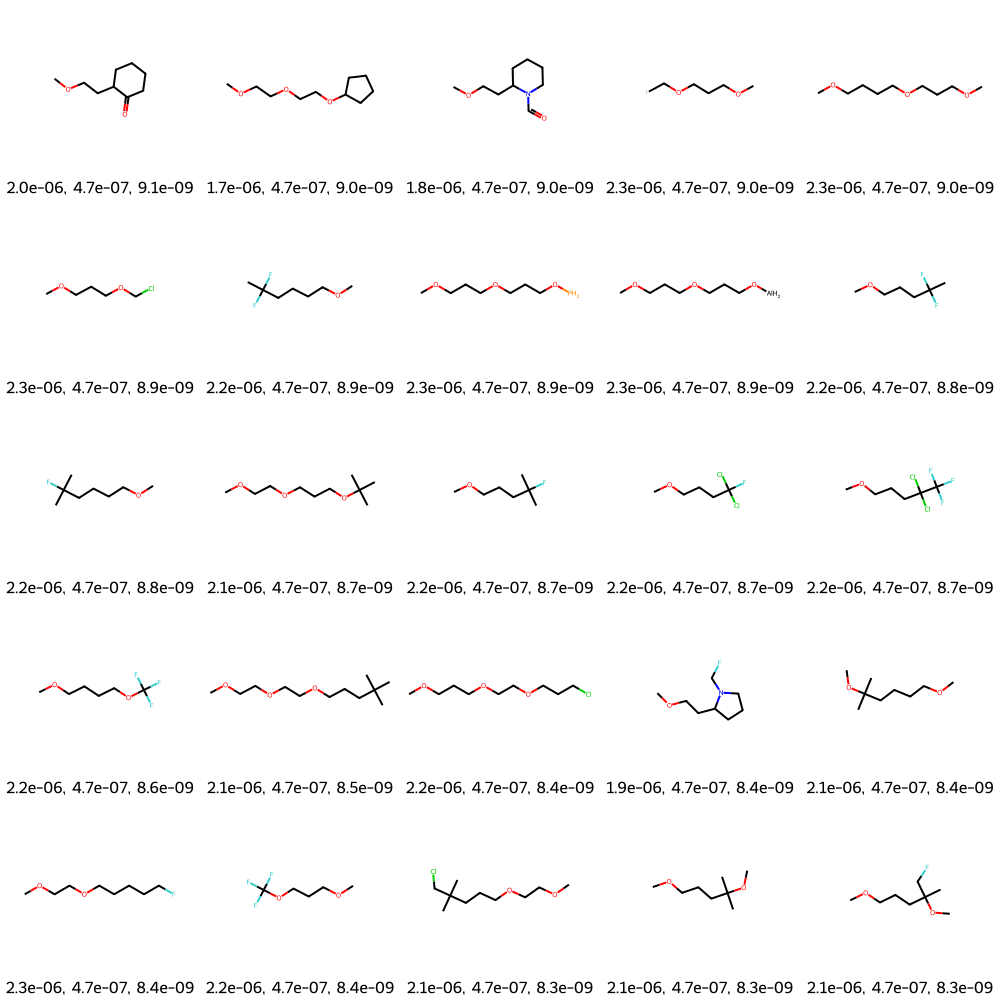

In [76]:
PandasTools.FrameToGridImage(df_new_.iloc[50:75], legendsCol="pred_comb", molsPerRow=5)

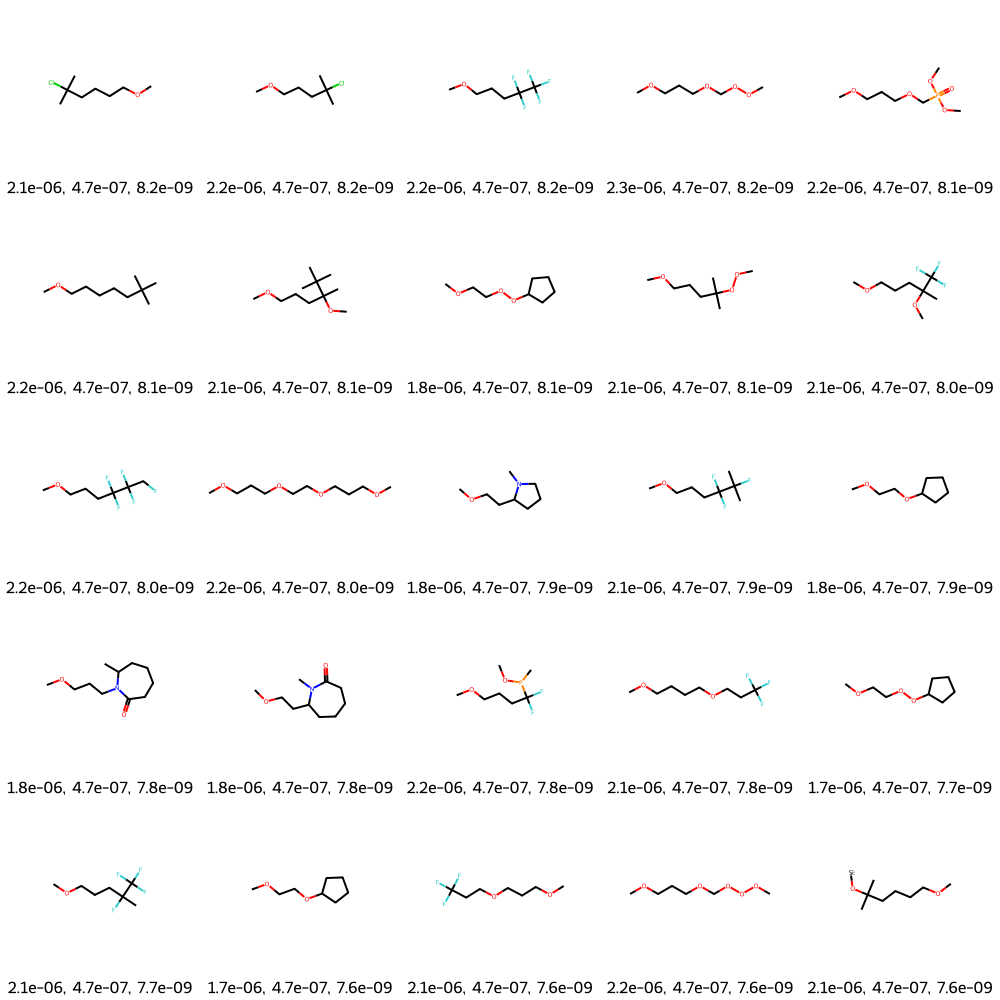

In [77]:
PandasTools.FrameToGridImage(df_new_.iloc[75:100], legendsCol="pred_comb", molsPerRow=5)

In [78]:
%%bash
ls -ltr

total 2634704
-rw-r--r--  1 riteshk  staff  519992928 Apr 17 14:47 unlabel_1mil_ecfp_pca_add_feat_iter_6.csv
-rw-r--r--@ 1 riteshk  staff      15965 Apr 17 14:48 just_label_iter_6.csv
-rw-r--r--@ 1 riteshk  staff     935241 Apr 17 15:03 Activelearning-batch5.xlsx
-rw-r--r--@ 1 riteshk  staff      77906 Apr 17 15:15 label_ecfp_pca_add_feat_iter_6_041724.csv
-rw-r--r--  1 riteshk  staff     311833 Apr 17 17:38 pairwise_iter6_041724.pkl
-rw-r--r--  1 riteshk  staff     311808 Apr 17 17:38 matern_iter6_041724.pkl
-rw-r--r--  1 riteshk  staff     311865 Apr 17 17:38 rq_iter5_041724.pkl
-rw-r--r--  1 riteshk  staff     311994 Apr 17 17:38 rbfexpsin_iter5_041724.pkl
-rw-r--r--  1 riteshk  staff  825219001 Apr 17 17:41 preds_uncer_ei_unlabel_1mil_iter6_041724.csv
-rw-r--r--@ 1 riteshk  staff    1451535 Apr 17 17:42 sugg_gpr_bma_iter_6.ipynb


**tSNE for top 5000**

In [91]:
## choosing top 5000 after removing Cl-containing compounds since they don't seem to work with AFBs!
print("Total # of Cl-containing compounds:", df_new['solv_comb_sm'].str.contains('Cl').sum())
bool_cl = df_new['solv_comb_sm'].str.contains('Cl').to_list()
cl_ind = df_new[bool_cl].index
mask = pd.Series(True, index=df_new.index)
mask.loc[cl_ind] = False
df_wo_cl = df_new[mask]
df_wo_cl

Total # of Cl-containing compounds: 114572


,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,-0.295080,...,0.196289,0.524380,0.196219,0.533146,0.177322,1.487349e-03,3.510667e-03,1.029649e-02,5.493567e-04,1.922895e-08
163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,-0.453350,...,0.194989,0.524388,0.194395,0.530847,0.176377,1.313502e-03,3.252584e-03,9.959198e-03,5.061058e-04,1.840467e-08
86859,86864,86867,86873,86879,COCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.733879,-1.391349,0.795406,-0.490061,...,0.194749,0.524147,0.193976,0.523709,0.176226,1.283902e-03,3.195202e-03,9.856640e-03,4.447651e-04,1.813241e-08
170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,-0.411474,...,0.194047,0.523170,0.193056,0.512665,0.175746,1.152412e-03,3.006397e-03,9.586726e-03,3.585166e-04,1.738860e-08
297404,297413,297418,297428,297442,COCCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.776737,-1.511074,0.882413,-0.374763,...,0.194727,0.521344,0.194054,0.511455,0.176446,1.187009e-03,3.040308e-03,9.577243e-03,3.633442e-04,1.738485e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594672,594690,594700,594720,594746,CCC1(CC)CCC(=O)C1(CC)CC,[Li+].F[P-](F)(F)(F)(F)F,0.217472,-1.227625,0.551617,0.010006,...,0.204356,-0.159134,0.207193,-0.214440,0.182973,2.407755e-09,4.237680e-09,1.697421e-07,2.602418e-12,2.055186e-13
538982,538998,539008,539028,539052,O=CC1(CC(F)F)CCSCC1,[Li+].F[P-](F)(F)(F)(F)F,0.208879,-1.107832,0.503163,-0.365220,...,0.201385,-0.142851,0.203259,-0.193828,0.180664,3.358132e-09,4.584617e-09,1.614634e-07,3.192729e-12,2.010593e-13
433459,433474,433483,433501,433523,O=CC1(CCF)CCC(F)(F)C1,[Li+].F[P-](F)(F)(F)(F)F,0.294739,-1.198675,0.575193,-0.500426,...,0.201548,-0.141867,0.202904,-0.208192,0.181232,3.302259e-09,4.431556e-09,1.588669e-07,2.156541e-12,1.980469e-13
388164,388178,388187,388203,388222,CCC1(C=O)CCC(F)(F)C1,[Li+].F[P-](F)(F)(F)(F)F,0.034484,-1.275622,0.324815,-0.154853,...,0.203289,-0.156972,0.205812,-0.226063,0.182099,2.172301e-09,3.645257e-09,1.533646e-07,1.374647e-12,1.867004e-13


In [92]:
df_new_5000 = df_wo_cl.iloc[:5000,:]
df_new_5000

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,-0.295080,...,0.196289,0.524380,0.196219,0.533146,0.177322,0.001487,0.003511,0.010296,0.000549,1.922895e-08
163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,-0.453350,...,0.194989,0.524388,0.194395,0.530847,0.176377,0.001314,0.003253,0.009959,0.000506,1.840467e-08
86859,86864,86867,86873,86879,COCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.733879,-1.391349,0.795406,-0.490061,...,0.194749,0.524147,0.193976,0.523709,0.176226,0.001284,0.003195,0.009857,0.000445,1.813241e-08
170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,-0.411474,...,0.194047,0.523170,0.193056,0.512665,0.175746,0.001152,0.003006,0.009587,0.000359,1.738860e-08
297404,297413,297418,297428,297442,COCCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.776737,-1.511074,0.882413,-0.374763,...,0.194727,0.521344,0.194054,0.511455,0.176446,0.001187,0.003040,0.009577,0.000363,1.738485e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201176,201183,201186,201195,201207,COCCCCN1C(=O)C(C)C(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.039092,-0.423983,1.322044,0.791314,...,0.221019,0.206963,0.225127,0.294614,0.198999,0.000175,0.000184,0.000474,0.000025,9.164949e-10
202369,202376,202379,202388,202400,COCCCCC(=O)C(=O)C(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.448730,-0.152089,1.383488,0.158595,...,0.203247,0.277536,0.205254,0.301409,0.182528,0.000068,0.000116,0.000592,0.000008,9.164826e-10
204360,204367,204370,204379,204391,CN1CCN2CCCCC2N1C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.798782,-0.634478,0.417154,0.174248,...,0.216509,0.231976,0.219303,0.280797,0.196655,0.000112,0.000174,0.000535,0.000017,9.156444e-10
262369,262377,262381,262391,262405,COP(=O)(OC)OC1CCCN(C(C)C)C1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.916380,-0.132072,0.417895,0.037628,...,0.240184,0.175655,0.247195,0.183762,0.216871,0.000062,0.000166,0.000695,0.000011,9.154880e-10


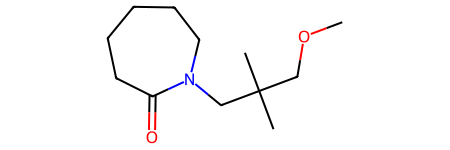

In [93]:
# Chem.MolFromSmiles('COC(C)C(C)(P(=O)(OC)OC)P(=O)(OC)OC')
# Chem.MolFromSmiles('COS(C)(OC)N(C)CC(C)(F)F')
Chem.MolFromSmiles('COCCCCC1C(=O)N(C)C(=O)N(C)C1=O')
Chem.MolFromSmiles('COCC(C)(C)CN1CCCCCC1=O')

In [ ]:
# df_unlabel_uniq_ = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
# df_unlabel_uniq_

In [94]:
df_comb_tsne = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,-0.272648,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414


In [95]:
list_suggest_bool = df_comb_tsne['solv_comb_sm'].isin(df_new_5000['solv_comb_sm'])
sugg_ind = [i for i in range(len(list_suggest_bool)) if list_suggest_bool[i] == True]
list_label_pool = df_comb_tsne['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
# sugg_ind_1 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2))]
# sugg_ind_2 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2), len(sugg_ind))]
df_comb_tsne['database'] = 'unlabel'
# df_comb_tsne.loc[sugg_ind_1, 'database'] = 'sugg_5th_peiyuan'
# df_comb_tsne.loc[sugg_ind_2, 'database'] = 'sugg_5th_ritesh'
df_comb_tsne.loc[sugg_ind, 'database'] = 'sugg_all'
df_comb_tsne.loc[label_ind, 'database'] = 'label'
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


In [96]:
len(sugg_ind)
# sugg_ind
df_comb_tsne['database'].unique()

array(['unlabel', 'sugg_all', 'label'], dtype=object)

cluster regions rather than assigning randomly

In [97]:
df_comb_tsne_sugg = df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_all']
X_comb_tsne = df_comb_tsne_sugg.iloc[:,-3:-1]
X_comb_tsne

,TSNE_0,TSNE_1
427,20.200350,24.282938
735,-20.417168,-4.034942
1144,-20.417671,-4.040377
1155,20.138859,24.319561
1227,19.959679,23.882128
...,...,...
386083,-15.419160,36.040916
386464,-14.091222,-11.254444
386711,-25.198235,1.801201
386763,-22.201046,-6.085480


In [98]:
kmeans = KMeans(random_state=0).fit(X_comb_tsne) ## using # of clusters found by kmeans method

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

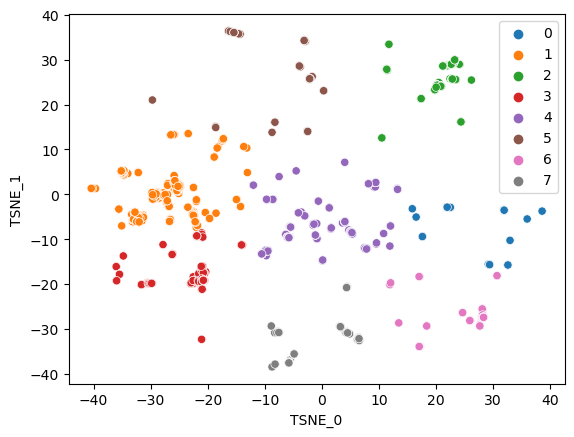

In [99]:
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

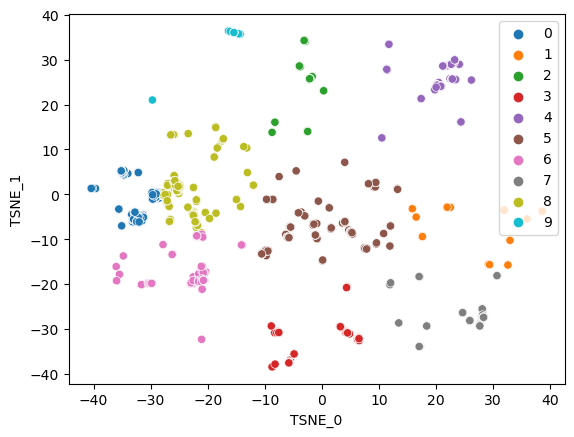

In [100]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_comb_tsne) ## fixing # of clusters to 10
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [101]:
row_label = df_comb_tsne.loc[df_comb_tsne['database'] == 'label']
df_comb_tsne_sugg['database'] = [('sugg_6th_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_comb_tsne_ = pd.concat([row_label, df_comb_tsne_sugg], axis=0)
df_comb_tsne_

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_76694/2324715301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_tsne_sugg['database'] = [('sugg_6th_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
1050,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,468.042638,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,99.104799,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label
3279,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,104.083730,186.939685,1.0,0.0,150,50,2,22.556498,28.949097,label
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,99.104799,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label
5684,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,88.088815,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386083,COCCCCCOOCCCOOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.963041,-1.537202,0.930112,-0.000216,-0.598388,0.780594,0.817360,0.704008,...,222.146724,144.001775,1.0,0.0,150,50,2,-15.419160,36.040916,sugg_6th_9
386464,COCCC1CCCN(C(=O)C(F)F)C1,[Li+].O=C1O[B-](F)(F)OC1=O,0.751896,0.844789,0.729120,0.442497,-1.227714,-0.132727,1.217904,-0.219517,...,221.122735,144.001775,1.0,0.0,150,50,2,-14.091222,-11.254444,sugg_6th_6
386711,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,185.141579,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_6th_8
386763,COC1CCCCCC(=O)OC(C)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.135297,-0.466424,0.870969,-0.693492,-0.429577,0.719366,-0.422886,-0.750610,...,200.141244,144.001775,1.0,0.0,150,50,2,-22.201046,-6.085480,sugg_6th_8


In [102]:
df_new_5000['rank'] = [i for i in range(1,5001)]
df_comb_tsne_ = df_comb_tsne_.merge(df_new_5000[['solv_comb_sm', 'salt_comb_sm', 'rank']], on=['solv_comb_sm', 'salt_comb_sm'], how='left')
df_comb_tsne_

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_76694/694021055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_5000['rank'] = [i for i in range(1,5001)]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
2,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,186.939685,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN
3,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
4,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3785,COCCCCCOOCCCOOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.963041,-1.537202,0.930112,-0.000216,-0.598388,0.780594,0.817360,0.704008,...,144.001775,1.0,0.0,150,50,2,-15.419160,36.040916,sugg_6th_9,4797.0
3786,COCCC1CCCN(C(=O)C(F)F)C1,[Li+].O=C1O[B-](F)(F)OC1=O,0.751896,0.844789,0.729120,0.442497,-1.227714,-0.132727,1.217904,-0.219517,...,144.001775,1.0,0.0,150,50,2,-14.091222,-11.254444,sugg_6th_6,3226.0
3787,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_6th_8,1009.0
3788,COC1CCCCCC(=O)OC(C)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.135297,-0.466424,0.870969,-0.693492,-0.429577,0.719366,-0.422886,-0.750610,...,144.001775,1.0,0.0,150,50,2,-22.201046,-6.085480,sugg_6th_8,3983.0


In [114]:
df_comb_tsne_.loc[df_comb_tsne_['solv_comb_sm'] == 'COCCOCC(F)(OC)C(F)(F)F']
df_comb_tsne_.loc[df_comb_tsne_['solv_comb_sm'] == 'COCCCCN1C(=O)C(C)C(C)C1=O']
# df_comb_tsne_.loc[df_comb_tsne_['rank'] == 4196]

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
2163,COCCCCN1C(=O)C(C)C(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.039092,-0.423983,1.322044,0.791314,-0.456611,0.178834,0.862903,0.843868,...,186.939685,1.0,0.0,150,50,2,-22.577623,-19.227299,sugg_6th_6,4996.0


In [104]:
df_comb_tsne_.to_csv('iter_6_top5000_sugg_ei_unique_explore.csv')

In [92]:
df_comb_tsne['database'].unique()
df_comb_tsne_['database'].unique()
df_comb_tsne_.shape

(5118, 33)

Interactive tSNE plot (Himi's code)

In [105]:
## pick only rows for label, sugg_2nd_peiyuan, and sugg_2nd_ritesh -> not using it but rather clusters from kmeans
# df_comb_tsne__ = df_comb_tsne_.loc[df_comb_tsne['database'] != 'unlabel'] ## somehow this is not working
df_comb_tsne__ = df_comb_tsne_.copy()
df_comb_tsne__

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
2,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,186.939685,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN
3,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
4,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3785,COCCCCCOOCCCOOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.963041,-1.537202,0.930112,-0.000216,-0.598388,0.780594,0.817360,0.704008,...,144.001775,1.0,0.0,150,50,2,-15.419160,36.040916,sugg_6th_9,4797.0
3786,COCCC1CCCN(C(=O)C(F)F)C1,[Li+].O=C1O[B-](F)(F)OC1=O,0.751896,0.844789,0.729120,0.442497,-1.227714,-0.132727,1.217904,-0.219517,...,144.001775,1.0,0.0,150,50,2,-14.091222,-11.254444,sugg_6th_6,3226.0
3787,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_6th_8,1009.0
3788,COC1CCCCCC(=O)OC(C)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.135297,-0.466424,0.870969,-0.693492,-0.429577,0.719366,-0.422886,-0.750610,...,144.001775,1.0,0.0,150,50,2,-22.201046,-6.085480,sugg_6th_8,3983.0


In [106]:
# df_comb_tsne__['database'].values.tolist()
df_comb_tsne__['database'].unique()

array(['label', 'sugg_6th_4', 'sugg_6th_8', 'sugg_6th_3', 'sugg_6th_5',
       'sugg_6th_9', 'sugg_6th_7', 'sugg_6th_6', 'sugg_6th_1',
       'sugg_6th_0', 'sugg_6th_2'], dtype=object)

In [107]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_comb_tsne__,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_comb_tsne__.solv]
smile = df_comb_tsne__['solv_comb_sm'].values.tolist()
database_class = df_comb_tsne__['database'].values.tolist()
ind = df_comb_tsne__.index.values.tolist()
rank = df_comb_tsne__['rank'].values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, rank=rank, color=df_comb_tsne__['database'].map({'sugg_6th_0':'cyan', 'sugg_6th_1':'orange', 'sugg_6th_2':'gray',
                                                                                                                                                                                       'sugg_6th_3':'teal', 'sugg_6th_4':'green', 'sugg_6th_5':'yellow', 
                                                                                                                                                                                       'sugg_6th_6':'red', 'sugg_6th_7':'purple', 'sugg_6th_8':'lime',
                                                                                                                                                                                       'sugg_6th_9':'magenta', 'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Rank: @rank </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-4; Top 10000 from model)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_041724_explore.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-6/interactive_map_sugg_al_041724_explore.html'

**Finding from top 5000 predictions: exploit**

In [108]:
df_exploit = df_unlabel_.copy()
df_exploit['norm_capacity_3_avg_pred'] = df_exploit[['norm_capacity_3_pair', 'norm_capacity_3_matern', 'norm_capacity_3_rq', 'norm_capacity_3_rbfexpsin']].mean(axis=1)
bool_cl_exp = df_exploit['solv_comb_sm'].str.contains('Cl').to_list()
cl_ind_exp = df_exploit[bool_cl_exp].index
mask_exp = pd.Series(True, index=df_exploit.index)
mask_exp.loc[cl_ind_exp] = False
df_exploit_wo_cl = df_exploit[mask_exp]
df_exploit_wo_cl

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,norm_capacity_3_avg_pred
0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,...,0.036388,0.213131,-0.028833,0.190237,4.352759e-07,9.271914e-07,0.000017,4.484913e-09,2.056377e-11,-0.001498
1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,...,0.020779,0.223812,0.000191,0.199810,1.777955e-06,2.647597e-06,0.000025,3.790661e-08,3.210314e-11,0.015130
2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,...,-0.048656,0.230271,-0.124979,0.203155,1.163366e-07,3.916610e-07,0.000012,2.125906e-09,1.264102e-11,-0.100128
3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,...,0.136671,0.202137,0.127638,0.183898,4.991655e-06,6.659768e-06,0.000051,1.425624e-07,7.471900e-11,0.131757
4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,...,0.025879,0.216916,-0.030867,0.192918,3.926163e-07,9.149222e-07,0.000018,6.352898e-09,2.134848e-11,-0.011355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,...,-0.069872,0.243804,-0.166776,0.213277,1.192621e-07,7.913179e-07,0.000019,3.046115e-09,1.959003e-11,-0.128959
999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,...,-0.070840,0.260922,-0.109416,0.226576,5.935917e-07,4.345367e-06,0.000047,6.411212e-08,4.814291e-11,-0.096271
999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,...,0.017982,0.263059,-0.023406,0.228187,3.023526e-06,2.070834e-05,0.000172,4.757334e-07,1.809392e-10,-0.007999
999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,...,-0.085858,0.273279,-0.237278,0.236896,6.853827e-08,2.912628e-06,0.000068,1.161471e-08,6.318782e-11,-0.189038


In [127]:
df_exploit_5000 = df_exploit_wo_cl.sort_values(by=['norm_capacity_3_avg_pred'], ascending=False).iloc[:5000,:]
df_exploit_5000['rank'] = [i for i in range(1,5001)]
df_exploit_5000

,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,...,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,norm_capacity_3_avg_pred,rank
302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,-0.295080,...,0.196219,0.533146,0.177322,0.001487,0.003511,0.010296,0.000549,1.922895e-08,0.526965,1
163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,-0.453350,...,0.194395,0.530847,0.176377,0.001314,0.003253,0.009959,0.000506,1.840467e-08,0.523396,2
86859,86864,86867,86873,86879,COCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.733879,-1.391349,0.795406,-0.490061,...,0.193976,0.523709,0.176226,0.001284,0.003195,0.009857,0.000445,1.813241e-08,0.520899,3
170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,-0.411474,...,0.193056,0.512665,0.175746,0.001152,0.003006,0.009587,0.000359,1.738860e-08,0.515127,4
297404,297413,297418,297428,297442,COCCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.776737,-1.511074,0.882413,-0.374763,...,0.194054,0.511455,0.176446,0.001187,0.003040,0.009577,0.000363,1.738485e-08,0.514644,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275315,275324,275329,275339,275353,COCCCOC(=O)C1CCCN1C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.448684,0.796290,1.077439,0.580102,...,0.242085,0.303455,0.212091,0.000285,0.000387,0.000917,0.000067,1.658153e-09,0.274884,4996
63896,63901,63903,63906,63911,CCOCCP(=O)(CC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.009239,-1.134707,0.815208,0.076368,...,0.188135,0.274666,0.171785,0.000027,0.000052,0.000327,0.000002,5.167558e-10,0.274879,4997
831571,831596,831610,831639,831676,COCCCCOS(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.977876,-1.170342,0.983390,-0.012219,...,0.203701,0.277569,0.183534,0.000060,0.000105,0.000473,0.000005,7.559156e-10,0.274876,4998
296885,296894,296899,296909,296923,COC1CCN2C(=O)CCCC2C1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.457782,-0.388281,1.192469,0.197146,...,0.224812,0.289139,0.201809,0.000142,0.000246,0.000789,0.000028,1.287517e-09,0.274872,4999


In [110]:
df_tsne_exploit = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
list_exploit_bool = df_tsne_exploit['solv_comb_sm'].isin(df_exploit_5000['solv_comb_sm'])
exploit_ind = [i for i in range(len(list_exploit_bool)) if list_exploit_bool[i] == True]
list_label_pool = df_tsne_exploit['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
df_tsne_exploit['database'] = 'unlabel'
df_tsne_exploit.loc[exploit_ind, 'database'] = 'exploit'
df_tsne_exploit.loc[label_ind, 'database'] = 'label'
df_tsne_exploit

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


In [129]:
df_tsne_exploit_sugg = df_tsne_exploit.loc[df_tsne_exploit['database'] == 'exploit']
# X_tsne_exploit = df_tsne_exploit_sugg.iloc[:,-3:-1]
# kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne_exploit) ## using # of clusters found by kmeans method
# sns.scatterplot(x=df_tsne_exploit_sugg['TSNE_0'], y=df_tsne_exploit_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [130]:
# df_tsne_exploit_sugg['norm_capacity_3_avg_pred'] = df_exploit_10000['norm_capacity_3_avg_pred']
df_tsne_exploit_sugg = df_tsne_exploit_sugg.merge(df_exploit_5000[['solv_comb_sm', 'norm_capacity_3_avg_pred', 'rank']], on='solv_comb_sm', how='left')
df_tsne_exploit_sugg

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred,rank
0,COP(=O)(OC)OP,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.562406,-1.128913,1.184731,-0.439677,-0.025809,-0.102259,0.229179,0.346099,...,1.0,0.0,150,50,2,30.916122,-18.803947,exploit,0.280131,4543
1,COCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.863536,-1.039067,1.081461,-0.406529,-0.227115,0.260969,0.755056,0.576431,...,1.0,0.0,150,50,2,20.200350,24.282938,exploit,0.377815,695
2,COP(C)(=O)O[AlH2],[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.603479,-1.143439,1.165883,-0.352102,0.087478,-0.056811,0.257733,0.317275,...,1.0,0.0,150,50,2,-8.869445,-38.642567,exploit,0.287297,3991
3,COP(C)(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571544,-1.117965,1.153550,-0.344366,0.030375,-0.090227,0.187540,0.329235,...,1.0,0.0,150,50,2,30.952755,-18.879631,exploit,0.283515,4274
4,COP(=O)(F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.635526,-0.973601,1.231374,-0.400522,0.118732,-0.152526,0.194185,0.225185,...,1.0,0.0,150,50,2,30.886734,-18.564882,exploit,0.278657,4658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,1.0,0.0,150,50,2,-21.946915,-9.196156,exploit,0.413358,309
4991,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,1.0,0.0,150,50,2,-21.917328,-9.234112,exploit,0.348111,1175
4992,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,1.0,0.0,150,50,2,28.366770,-27.364807,exploit,0.337482,1449
4993,COCCOCCCOCCSC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.850928,-0.981361,0.924863,-0.120144,-0.634089,0.778615,0.755842,0.358679,...,1.0,0.0,150,50,2,28.304045,-27.381954,exploit,0.296918,3327


/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

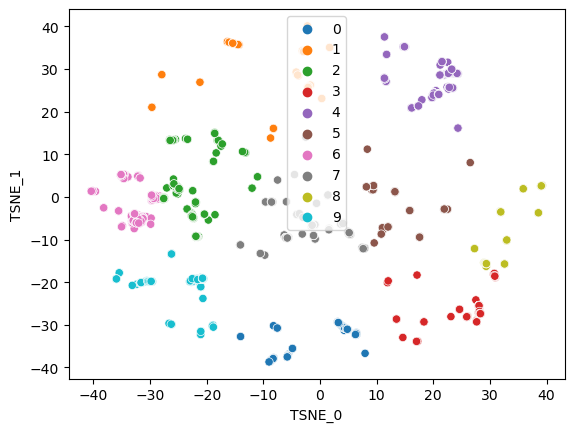

In [131]:
X_tsne_exploit = df_tsne_exploit_sugg.iloc[:,-5:-3]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne_exploit) ## using # of clusters found by kmeans method
sns.scatterplot(x=df_tsne_exploit_sugg['TSNE_0'], y=df_tsne_exploit_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [132]:
row_label = df_tsne_exploit.loc[df_tsne_exploit['database'] == 'label']
df_tsne_exploit_sugg['database'] = [('exploit_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_tsne_exploit_ = pd.concat([row_label, df_tsne_exploit_sugg], axis=0)
df_tsne_exploit_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred,rank
1050,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN,NaN
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN,NaN
3279,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN,NaN
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN,NaN
5684,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,1.0,0.0,150,50,2,-21.946915,-9.196156,exploit_2,0.413358,309.0
4991,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,1.0,0.0,150,50,2,-21.917328,-9.234112,exploit_2,0.348111,1175.0
4992,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,1.0,0.0,150,50,2,28.366770,-27.364807,exploit_3,0.337482,1449.0
4993,COCCOCCCOCCSC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.850928,-0.981361,0.924863,-0.120144,-0.634089,0.778615,0.755842,0.358679,...,1.0,0.0,150,50,2,28.304045,-27.381954,exploit_3,0.296918,3327.0


In [133]:
len(kmeans.labels_)
# len(row_label)

4995

In [134]:
df_tsne_exploit_['norm_capacity_3_avg_pred']

1050         NaN
2373         NaN
3279         NaN
4139         NaN
5684         NaN
          ...   
4990    0.413358
4991    0.348111
4992    0.337482
4993    0.296918
4994    0.278170
Name: norm_capacity_3_avg_pred, Length: 5125, dtype: float64

In [135]:
df_tsne_exploit_.to_csv('iter_6_top5000_sugg_ei_unique_exploit.csv')

In [125]:
df_tsne_exploit_['database'].unique()

array(['label', 'exploit_3', 'exploit_4', 'exploit_0', 'exploit_2',
       'exploit_9', 'exploit_7', 'exploit_6', 'exploit_1', 'exploit_8',
       'exploit_5'], dtype=object)

In [136]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_tsne_exploit_,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_tsne_exploit_.solv]
smile = df_tsne_exploit_['solv_comb_sm'].values.tolist()
database_class = df_tsne_exploit_['database'].values.tolist()
ind = df_tsne_exploit_.index.values.tolist()
pred = ([0.0]*110) + [round(val, 3) for val in df_tsne_exploit_['norm_capacity_3_avg_pred'].iloc[110:].values.tolist()]
rank = df_tsne_exploit_['rank'].values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_tsne_exploit_['TSNE_0'], y=df_tsne_exploit_['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, pred=pred, rank=rank, color=df_tsne_exploit_['database'].map({'exploit_0':'cyan', 'exploit_1':'orange', 'exploit_2':'gray',
                                                                                                                                                                                       'exploit_3':'teal', 'exploit_4':'green', 'exploit_5':'yellow', 
                                                                                                                                                                                       'exploit_6':'red', 'exploit_7':'purple', 'exploit_8':'lime',
                                                                                                                                                                                       'exploit_9':'magenta', 'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Prediction: @pred </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Rank: @rank </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-4; Top 10000 predictions)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_041724_exploit.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-6/interactive_map_sugg_al_041724_exploit.html'